##   NYC Airbnb data - Modeling the listing price

    By Muluemebet Ayalew
       April,2020

In [1]:
#Important libraries

import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import skew, zscore    # to calculate the skewness of numerical columns and compute z score
import statsmodels.api as sm     # to graph QQplot
from statsmodels.formula.api import ols  # for regression,OLS

from sklearn import preprocessing  # to use label encoding
from sklearn.model_selection import train_test_split # to split the data into training and test set

# to select parameters using cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error # performance measures

# to make models
from sklearn.linear_model import LinearRegression    # to make regression model
from sklearn.linear_model import Lasso, LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import Pool, CatBoostRegressor
#from sklearn.tree import export_graphviz  # make the tree graph
%matplotlib inline


## 1) Get the original and cleaned data 

In [2]:
#original data downloaded on end of January
ny= pd.read_csv("listings.csv", parse_dates=["last_review"]) # read the last_review column as datetime

In [3]:
ny.columns  # list of column names

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

## Read the cleaned data 
This data has non zero price, none NaN for reviews_per_month. New features such as is_hotel, distance from some point of interest.

In [4]:
# read the cleaned data for further analysis
new_ny= pd.read_csv("NYC_cleaned.csv", parse_dates=["last_review"])

In [5]:
new_ny.shape # now the shape of the dataframe is changed


(50583, 22)

In [6]:
new_ny.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'is_hotel', 'location',
       'dist_nearest_SubwayStation', 'dist_nearest_SubwayEntrance',
       'dist_from_TimeSqr', 'dist_from_PennStation'],
      dtype='object')

## 2) Dealing with Outliers 
 
 The data with price beyond three standard deviation from the mean price are removed from the analysis. For both training and test data the price above 1202 is considered outlier. This number is obtained by computing mean plus three standard deviation of the whole data set. The price above this value is treated as outlier. 

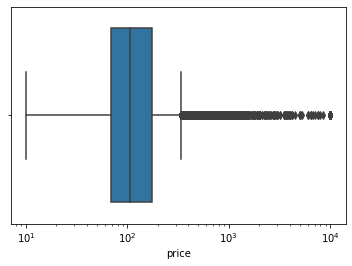

In [7]:
_=sns.boxplot("price", data=new_ny) 
_=plt.xscale("log")

In [9]:
# removing outliers  beyond three standard deviation from the mean
mean_p=new_ny["price"].mean()
std_p=new_ny["price"].std()
three_sigma= mean_p + (3*std_p)

In [10]:
three_sigma # upper limit for price

1202.6215388898568

In [11]:
# detaframe with prices below (mean +3 *standard_deviation)
clean_ny= new_ny[new_ny["price"]<three_sigma]
# the new dataframe after prices above three standard deviations from the mean removed 
clean_ny.shape

(50352, 22)

## 3) Feature Encoding 

The data has catagorical variables. we need to encode those variables.  For the variables neighbourhood_group and room_type, dummy variables are created using pandas method get_dummies(). However, the variable neighbourhood contains 223 unique values and creating dummy makes the model complex and computationaly expensive. A better way to hand this is by using target encoding. The median price for each group is computed and used as a predictor variable. But this has to be done after spliting the data into training and test data. 

#### Creat dummies for nighbourhood_group and room_type

In [13]:
# get catagorical columns
clean_ny.select_dtypes("object").columns

Index(['name', 'host_name', 'neighbourhood_group', 'neighbourhood',
       'room_type', 'location'],
      dtype='object')

Right now, we are interested with neighbourhood_group and room_type. We will deal with neighbourhood later.  

In [13]:
#convert neighbourhood_group and room_type into dummy variables
neighbourg_room= pd.get_dummies(clean_ny[["neighbourhood_group", "room_type"]],drop_first=True)

In [14]:
neighbourg_room.head(2) # see the dummy variables

,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,0,1,0,0,0,0,0
1,1,0,0,0,0,0,0


In [15]:
# merge the dataframes with dummy variables to the original data
merged= pd.concat([clean_ny,neighbourg_room], axis=1)


In [16]:
merged.shape # the shape after creating dummy variebles

(50352, 29)

## 4) Split the data into training and test set 
Before performing target encoding we need to split the data into training and validating. Variables such as distance form Time Square and distance from Penn Station are highly correlated. Only one variable(distance from Penn Station) is included in the analysis. Distance from subwy entrance and distance from subway station are also correlated. Only distance from subwy entrance is included in the model. 
The whole data set including the response variable is splited into training and test data. To make the follow up modelling easier, the training and test data contains all the variables including variables that will not be included in the model. Base on the need and type of encoding needed for specific algorithm, we will modify or choose predictor variables from the whole list. 

In [17]:
X=merged   # the whole data set
y=merged["price"]  # target,response variable

# split training(70%) and test data(30%)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.3, random_state=42)

In [18]:
print("training_data_shape : ", X_train.shape)
print("test_data_shape : ", X_test.shape)

training_data_shape :  (35246, 29)
test_data_shape :  (15106, 29)


### Target encoding for neighbourhood
Since nighbourhood has large categories, target encoding is used. Target encoding is performed for both training and test data separately. 

**Encoding for training data**

In [19]:
# # group the neighbourhood by median price
train=X_train.groupby("neighbourhood")["price"].agg("median").reset_index()

# encode the neighbourhood by its median price 
train_encoder= {train.neighbourhood[i]: train.price[i] for i in range(train.shape[0])}

# map the encoder
X_train=X_train.copy()
X_train["neighb_encoded"] = X_train["neighbourhood"].map(train_encoder)

# look at the group median price
train.columns=['neighbourhood', 'median price']
train.head(2) 


,neighbourhood,median price
0,Allerton,65.0
1,Arden Heights,75.0


**Encoding for test data**

In [20]:
# group the neighbourhood by median price
test=X_test.groupby("neighbourhood")["price"].agg("median").reset_index()

# encode the neighbourhood by its median price 
test_encoder= {test.neighbourhood[i]: test.price[i] for i in range(test.shape[0])}

# map the encoder
X_test= X_test.copy()
X_test["neighb_encoded"] = X_test["neighbourhood"].map(test_encoder) 




## 5) Prediction 

## 5.1)  Linear model with two senarios

   ### a) Without transformation of response variable

In [21]:
# all the selected features 
col=['neighb_encoded', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', \
     'calculated_host_listings_count', 'availability_365', 'is_hotel', \
     'dist_nearest_SubwayEntrance','dist_from_PennStation', 'neighbourhood_group_Brooklyn', \
     'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens', \
     'neighbourhood_group_Staten Island', 'room_type_Hotel room', 'room_type_Private room', \
     'room_type_Shared room']
print(len(col)) # number of predictor variables

16


In [22]:
# fit with Linear regrassion with the selected predictor variables
Xl_train= X_train[col]
Xl_test= X_test[col]
linear=LinearRegression().fit(Xl_train,y_train)#Xl_train,y_train)

In [23]:
linear.score(Xl_test,y_test) # R2 for test data set

0.32649306462170424

In [110]:
# Predict for training data
trainl_pred=linear.predict(Xl_train)

#predict for test data
testl_pred= linear.predict(Xl_test)

### See the performance of the model for training and test data

In [25]:
def model_output(y_true, y_pred):
    _=plt.scatter(y_true, y_pred) # see the predicted and actual values
    _=plt.xlabel("Actual")
    _=plt.ylabel("Predicted")
    
    #performance measure
    print("r2 = ",r2_score(y_true,y_pred)) # r2
    print("mean_absolute_error = ", mean_absolute_error(y_true,y_pred))
    print("mean_squared_error = ", mean_squared_error(y_true, y_pred))    
    

 Performance of training data
r2 =  0.326612798786566
mean_absolute_error =  55.14786732246464
mean_squared_error =  9671.908373854427
 Performance of test data 
r2 =  0.32649306462170424
mean_absolute_error =  56.10848811973174
mean_squared_error =  9970.002325807229


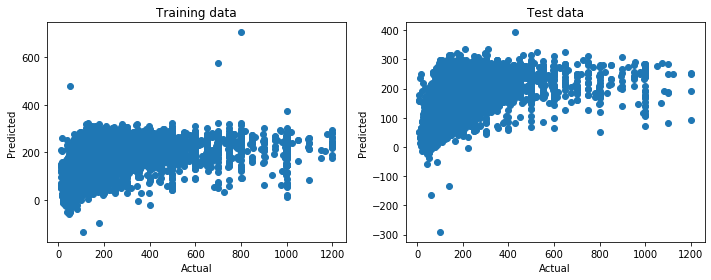

In [26]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
print("\033[1m Performance of training data\033[0m")# print in bold
model_output(y_train,trainl_pred)
plt.title("Training data")

plt.subplot(1,2,2)
print("\033[1m Performance of test data \033[0m") # print in bold
model_output(y_test,testl_pred)
plt.title("Test data")
plt.tight_layout()


As we can see from the above plot and performace measures, the model doesn't perform well. Let us see how we can improve the preformance of the model. First let us check if the assumptions for linear regession are satisfied.

## Check  the assumptions to use  linear regression
The package statsmodels is used to diagnose the assumption for linear regression.

In [31]:
# Import regression modules
#import statsmodels.api as sm
#from statsmodels.formula.api import ols

In [27]:
datalm=pd.concat((Xl_train, y_train), axis=1) # train data 

In [28]:
datalm.shape

(35246, 17)

In [29]:
# make appropriate formate for column naming
datalm.columns= ['neighb_encoded', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'is_hotel', 'dist_nearest_SubwayEntrance',
       'dist_from_PennStation', 'neighbourhood_group_Brooklyn',
       'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens',
       'neighbourhood_group_Staten_Island', 'room_type_Hotel_room',
       'room_type_Private_room', 'room_type_Shared_room',"price"]

In [31]:
# Linear model using ordinary least square
lm=ols("price ~ neighb_encoded \
+ minimum_nights + number_of_reviews + reviews_per_month \
+ calculated_host_listings_count+availability_365 +\
 +is_hotel + dist_nearest_SubwayEntrance+ dist_from_PennStation\
 +neighbourhood_group_Brooklyn+ neighbourhood_group_Manhattan \
 + neighbourhood_group_Queens+ neighbourhood_group_Staten_Island\
+ room_type_Hotel_room +  room_type_Private_room+ room_type_Shared_room", datalm).fit()

In [32]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                     1068.
Date:                Fri, 24 Apr 2020   Prob (F-statistic):               0.00
Time:                        12:56:32   Log-Likelihood:            -2.1174e+05
No. Observations:               35246   AIC:                         4.235e+05
Df Residuals:                   35229   BIC:                         4.237e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                           104.7710      5.081     20.619      0.000      94.812     114.730
neighb_encoded                        0.7409      0.020     36.924      0.000       0.702       0.780
minimum_nights                       -0.3034      0.025    -11.920      0.000      -0.353      -0.254
number_of_reviews                    -0.1267      0.014     -9.125      0.000      -0.154      -0.099
reviews_per_month                    -0.7804      0.418     -1.868      0.062      -1.599       0.038
calculated_host_listings_count       -0.1903      0.017    -11.233      0.000      -0.224      -0.157
availability_365                      0.1034      0.004     24.634      0.000       0.095       0.112
is_hotel                             89.0927     11.585      7.690      0.000      66.385     111.800
dist_nearest_SubwayEntrance           0.3309      1.090      0.304      0.761      -1.805       2.466
dist_from_PennStation                -1.4858      0.200     -7.427      0.000      -1.878      -1.094
neighbourhood_group_Brooklyn          0.1563      3.596      0.043      0.965      -6.892       7.205
neighbourhood_group_Manhattan         2.5437      3.843      0.662      0.508      -4.989      10.077
neighbourhood_group_Queens            1.9851      3.792      0.524      0.601      -5.447       9.417
neighbourhood_group_Staten_Island    -2.1538      7.021     -0.307      0.759     -15.914      11.607
room_type_Hotel_room                -99.7735     12.909     -7.729      0.000    -125.076     -74.471
room_type_Private_room              -89.7841      1.122    -80.057      0.000     -91.982     -87.586
room_type_Shared_room              -112.9239      3.436    -32.869      0.000    -119.658    -106.190
==============================================================================
Omnibus:                    30319.244   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1086661.263
Skew:                           4.055   Prob(JB):                         0.00
Kurtosis:                      28.964   Cond. No.                     6.34e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.34e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Linearity 
The residual and fitted plot showed that the residual increases as the price increase.It is hard to assume linearity and constant variance. 

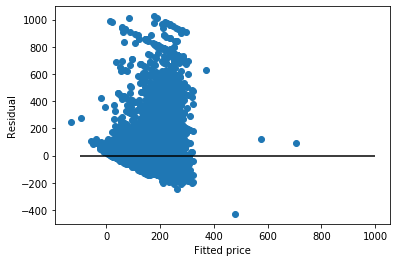

In [33]:
#check linearity,is there systematic relation ship between price and residuals. 
_=plt.scatter(lm.fittedvalues,lm.resid) # residula is actual minus predcted value
_=plt.xlabel("Fitted price")
_=plt.ylabel("Residual")
_=plt.hlines(0,-100,10**3)
#_=plt.xscale("log")


## Normality assumption 
The residual plot is skeweed to the right. We may need to use log transformation to reduce the skewness. 

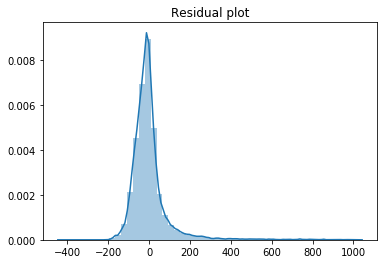

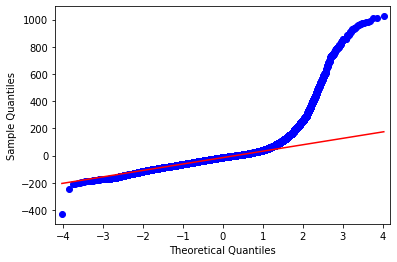

In [34]:
#distribution plot
sns.distplot(lm.resid)
_=plt.title("Residual plot")

# normality chack using qqplot, it looks normal with some deviation on larger values.
_=sm.qqplot(lm.resid, line="q")


### Outliers , Leveraging and influencial points
Outlier are data points far from the rest of the data. Leveraging points are values that have unusual combination of predictor variables and influencial variables can influence parameter estimation. There are outliers and leveraging values from the data as displayed and computed below.

In [35]:
 from statsmodels.stats import outliers_influence #.OLSInfluence

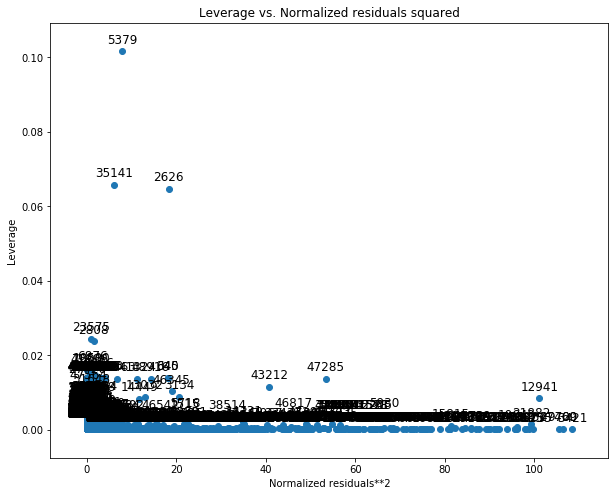

In [36]:
# check leveraging values
# data points with index  5379,35141, 2626 are leveraging points
from statsmodels.graphics.regressionplots import *
fig, ax = plt.subplots(figsize=(10,8))
_=plot_leverage_resid2(lm, ax = ax)


### Outliers

In [37]:
stud_res= lm.resid_pearson  # residuals
stud_res = pd.Series(stud_res) # store in panda series 
stud_res.index = lm.resid.index # get the index of the residuals

# get the index of outliers having studentized residuals above and below 2
outlier_index=stud_res[np.abs(stud_res)>2 ].index  
outlier_index; # index of outliers

### Leveraging points
 Leveraging points are data points with unusual combination of predictor variables. The first three indices(5379,35141, 2626) contain data containing the largerst minimum_night, the last two(23575, 2808) contain data that are farthest from PennStation. 

In [38]:
# leveraging indices
leverge_index=[5379,35141, 2626, 23575, 2808]

In [40]:
# combine the index for outlier are leveraging points
out_lev=np.concatenate((outlier_index,leverge_index), axis=0) 
out_lev=pd.Series(out_lev) # store in panda series 
out_lev.drop_duplicates(inplace=True) # drop the duplicates of index
out_lev=np.array(out_lev) # make array of indices

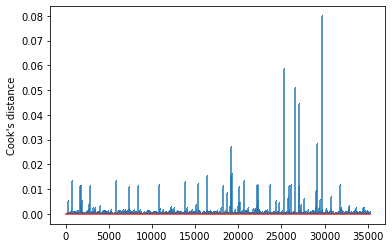

In [41]:
#since the cookis distance is below 1 ,there are no  influencial values 
influence = lm.get_influence()
#c is the distance and p is p-value
(c, p) = influence.cooks_distance
_=plt.stem(np.arange(len(c)), c, markerfmt=",", use_line_collection=True)
_=plt.ylabel("Cook's distance")
#_=plt.xlim((350,370))

In [ ]:
# influence plot, there are lots of outliers
# studentized residuals below -2 and above 2 are outliers
# 
_=influence_plot(lm)
#_=plt.hlines(-2,0,0.2, linestyles="dashed")
#_=plt.hlines(2,0,0.2, linestyles="dashed")

## b) Model after taking corrective measures
After removing the outliers and leveraging points, and log transformation of outcome variable, the model performs better. 

In [42]:
# linear model with log transformation of price(outcome variable) and removing outliers and leveraging points 
no_outlier_data= datalm.drop(out_lev, axis=0)
lm_corrected=ols("np.log(price) ~ neighb_encoded \
+ minimum_nights + number_of_reviews + reviews_per_month \
+ calculated_host_listings_count+availability_365 +\
 +is_hotel + dist_nearest_SubwayEntrance+ dist_from_PennStation\
 +neighbourhood_group_Brooklyn+ neighbourhood_group_Manhattan \
 + neighbourhood_group_Queens+ neighbourhood_group_Staten_Island\
+ room_type_Hotel_room +  room_type_Private_room+ room_type_Shared_room", no_outlier_data).fit()

In [43]:
lm_corrected.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(price)   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     3324.
Date:                Fri, 24 Apr 2020   Prob (F-statistic):               0.00
Time:                        13:00:16   Log-Likelihood:                -15195.
No. Observations:               34045   AIC:                         3.042e+04
Df Residuals:                   34028   BIC:                         3.057e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             4.5964      0.020    230.052      0.000       4.557       4.636
neighb_encoded                        0.0038   8.14e-05     46.557      0.000       0.004       0.004
minimum_nights                       -0.0028      0.000    -23.907      0.000      -0.003      -0.003
number_of_reviews                    -0.0002   5.39e-05     -3.416      0.001      -0.000   -7.84e-05
reviews_per_month                    -0.0013      0.002     -0.774      0.439      -0.004       0.002
calculated_host_listings_count       -0.0005   6.63e-05     -7.205      0.000      -0.001      -0.000
availability_365                      0.0004   1.66e-05     25.610      0.000       0.000       0.000
is_hotel                              0.5643      0.047     12.050      0.000       0.473       0.656
dist_nearest_SubwayEntrance           0.0170      0.004      4.017      0.000       0.009       0.025
dist_from_PennStation                -0.0159      0.001    -20.148      0.000      -0.017      -0.014
neighbourhood_group_Brooklyn          0.0488      0.014      3.496      0.000       0.021       0.076
neighbourhood_group_Manhattan         0.0779      0.015      5.218      0.000       0.049       0.107
neighbourhood_group_Queens            0.0300      0.015      2.037      0.042       0.001       0.059
neighbourhood_group_Staten_Island     0.0240      0.027      0.881      0.378      -0.029       0.077
room_type_Hotel_room                 -0.8561      0.052    -16.426      0.000      -0.958      -0.754
room_type_Private_room               -0.6763      0.004   -154.331      0.000      -0.685      -0.668
room_type_Shared_room                -1.0875      0.013    -81.270      0.000      -1.114      -1.061
==============================================================================
Omnibus:                      679.451   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              980.641
Skew:                           0.231   Prob(JB):                    1.14e-213
Kurtosis:                       3.692   Cond. No.                     6.50e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.5e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We can further simplify the model by removing the non-significant predictor variables that have large p-values. The variables reviews_per_month and neighbourhood_group_Staten_Island have high p-value. After removing those variables and making a model, we found that the variable neighbourhood_group_Queens has p-value greator than 0.05. Thus, it is removed from the model. The simplified version of the model is as follow. 
 

In [44]:
# to be removed , [6876, 7503,10500, 41896, 10156, 2703, 27426]
lm_simplified=ols("np.log(price) ~ neighb_encoded \
+ minimum_nights + number_of_reviews  \
+ calculated_host_listings_count+availability_365 \
 +is_hotel + dist_nearest_SubwayEntrance + dist_from_PennStation\
 +neighbourhood_group_Brooklyn+ neighbourhood_group_Manhattan \
+ room_type_Hotel_room +  room_type_Private_room+ room_type_Shared_room",\
                  no_outlier_data).fit()

In [45]:
lm_simplified.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(price)   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     4091.
Date:                Fri, 24 Apr 2020   Prob (F-statistic):               0.00
Time:                        13:00:29   Log-Likelihood:                -15198.
No. Observations:               34045   AIC:                         3.042e+04
Df Residuals:                   34031   BIC:                         3.054e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          4.6242      0.014    327.907      0.000       4.597       4.652
neighb_encoded                     0.0038   8.06e-05     46.862      0.000       0.004       0.004
minimum_nights                    -0.0027      0.000    -23.988      0.000      -0.003      -0.003
number_of_reviews                 -0.0002   4.38e-05     -4.729      0.000      -0.000      -0.000
calculated_host_listings_count    -0.0005   6.62e-05     -7.139      0.000      -0.001      -0.000
availability_365                   0.0004   1.65e-05     25.651      0.000       0.000       0.000
is_hotel                           0.5650      0.047     12.068      0.000       0.473       0.657
dist_nearest_SubwayEntrance        0.0184      0.004      4.419      0.000       0.010       0.027
dist_from_PennStation             -0.0163      0.001    -21.283      0.000      -0.018      -0.015
neighbourhood_group_Brooklyn       0.0242      0.007      3.630      0.000       0.011       0.037
neighbourhood_group_Manhattan      0.0528      0.008      6.400      0.000       0.037       0.069
room_type_Hotel_room              -0.8566      0.052    -16.438      0.000      -0.959      -0.754
room_type_Private_room            -0.6762      0.004   -154.333      0.000      -0.685      -0.668
room_type_Shared_room             -1.0879      0.013    -81.317      0.000      -1.114      -1.062
==============================================================================
Omnibus:                      682.486   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              986.092
Skew:                           0.231   Prob(JB):                    7.46e-215
Kurtosis:                       3.694   Cond. No.                     6.50e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.5e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [46]:
Xl_test.columns = ['neighb_encoded', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'is_hotel', 'dist_nearest_SubwayEntrance',
       'dist_from_PennStation', 'neighbourhood_group_Brooklyn',
       'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens',
       'neighbourhood_group_Staten_Island', 'room_type_Hotel_room',
       'room_type_Private_room', 'room_type_Shared_room']

In [111]:
trainl_corr_pred= lm_simplified.predict(datalm)
testl_corr_pred= lm_simplified.predict(Xl_test) # predict for test data

 Performance of training data
r2 =  0.5550602525995451
mean_absolute_error =  0.33059263399830646
mean_squared_error =  0.20038930203320043
 Performance of test data 
r2 =  0.5539342001238523
mean_absolute_error =  0.3301990034064161
mean_squared_error =  0.20334831111094345


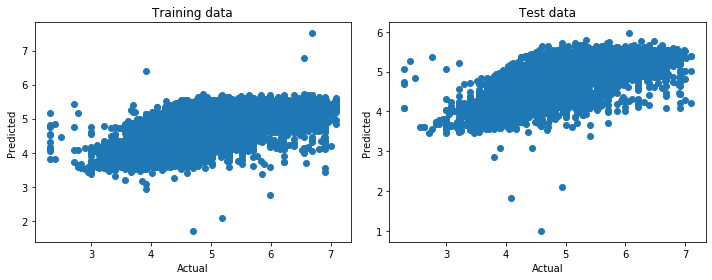

In [52]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
print("\033[1m Performance of training data\033[0m")
model_output(np.log(y_train), trainl_pred)
plt.title("Training data")

plt.subplot(1,2,2)
print("\033[1m Performance of test data \033[0m")
model_output(np.log(y_test),testl_pred)
plt.title("Test data")
plt.tight_layout()



### With log transformation of outcome variable(price) and removing outlier and leveraging points in sklearn
The model performed better after logtransformation of target variable(price).

In [53]:
yl_train_log=np.log(y_train.drop(out_lev, axis=0)) # log transformation of price for training data
yl_test_log= np.log(y_test) # log transformtion of price for test data

In [54]:
linear_log= LinearRegression().fit(Xl_train.drop(out_lev, axis=0),yl_train_log)
trainl_logpred= linear_log.predict(Xl_train.drop(out_lev, axis=0))
testl_logpred=linear_log.predict(Xl_test)


 Performance of training data
r2 =  0.6098272416266359
mean_absolute_error =  0.2969734455353672
mean_squared_error =  0.1429549407671976
 Performance of test data 
r2 =  0.5539610375611389
mean_absolute_error =  0.3302104155165739
mean_squared_error =  0.2033360767106637


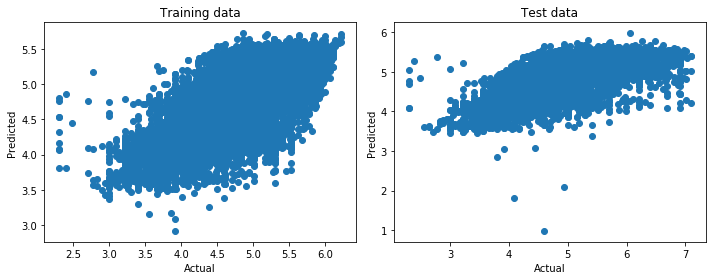

In [55]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
print("\033[1m Performance of training data\033[0m")
model_output(yl_train_log, trainl_logpred)
plt.title("Training data")

plt.subplot(1,2,2)
print("\033[1m Performance of test data \033[0m")
model_output(yl_test_log,testl_logpred)
plt.title("Test data")
plt.tight_layout()

In [56]:
# r2 for cross validation with 5-folds 
cross_val_score(linear_log, Xl_train.drop(out_lev, axis=0),yl_train_log, cv=5 )

array([0.6111325 , 0.61148855, 0.61709214, 0.61215972, 0.59302035])

### 5.2) Lesso regression 

In [57]:
# fit the model with different alpha value, the optimal alpha will be used to prediction
alphas=[0.0001,0.001, 0.01, 0.1, 1,10,20]
lassocv = LassoCV(alphas=alphas, cv=4, normalize=True).fit(Xl_train,y_train)

In [58]:
lassocv.alpha_# the best alpha

0.001

In [59]:
# using the optimal alpha
train_lasso_pred=lassocv.predict(Xl_train)
test_lasso_pred=lassocv.predict(Xl_test)

 Performance of training data
r2 =  0.32652717793095964
mean_absolute_error =  55.09072397473016
mean_squared_error =  9673.138152307038
 Performance of test data 
r2 =  0.3262165325026317
mean_absolute_error =  56.041298062099685
mean_squared_error =  9974.095863268376


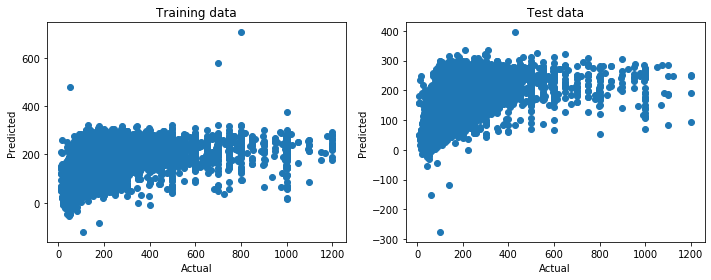

In [60]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
print("\033[1m Performance of training data\033[0m")# print in bold
model_output(y_train,train_lasso_pred)
plt.title("Training data")

plt.subplot(1,2,2)
print("\033[1m Performance of test data \033[0m") # print in bold
model_output(y_test,test_lasso_pred)
plt.title("Test data")
plt.tight_layout()


In [61]:
lassocv.coef_;

In [62]:
list(zip(Xl_train.columns, lassocv.coef_))

[('neighb_encoded', 0.7412618702357804),
 ('minimum_nights', -0.2905442964885181),
 ('number_of_reviews', -0.12334985017755526),
 ('reviews_per_month', -0.6610131860797201),
 ('calculated_host_listings_count', -0.18014850862919357),
 ('availability_365', 0.1006876735825594),
 ('is_hotel', 71.9331738298024),
 ('dist_nearest_SubwayEntrance', 0.0),
 ('dist_from_PennStation', -1.4539620812255987),
 ('neighbourhood_group_Brooklyn', -1.1995220882725453),
 ('neighbourhood_group_Manhattan', 0.823391150933106),
 ('neighbourhood_group_Queens', 0.0),
 ('neighbourhood_group_Staten Island', -1.2601131132382255),
 ('room_type_Hotel room', -79.56276195337824),
 ('room_type_Private room', -89.22640974985542),
 ('room_type_Shared room', -111.34423136707319)]

#### Selected variables using lasso regression 

['neighb_encoded', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'dist_from_PennStation', 'neighbourhood_group_Brooklyn',\
        'room_type_Private room', 'room_type_Shared room']


### 5.3)  K-nearest neighbours regression

In [65]:
#from sklearn.neighbors import KNeighborsRegressor

In [64]:
# Standardize the training and test data 
Xzt=zscore(Xl_train)
yzt=zscore(y_train)
Xz_test=zscore(Xl_test)
yz_test=zscore(y_test)

In [69]:
# fit the model with differnt k
k=np.arange(1,21) # k values 
kmt=np.empty(len(k))  # preformce of prediction for training data 
scr=np.empty(len(k))  # performance of prediction for test data
for i, n in enumerate(k):
    km= KNeighborsRegressor(n_neighbors=n)
    km.fit(Xzt,yzt)
    kmt[i]=km.score(Xzt,yzt)
    scr[i]=km.score(Xz_test,yz_test)  
    

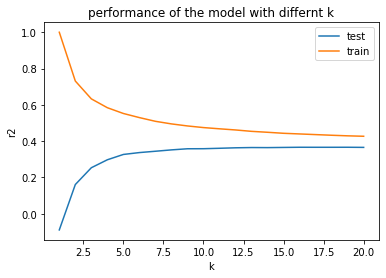

In [70]:
_=plt.plot(k,scr, label="test")
_=plt.plot(k,kmt, label="train")
_=plt.legend()
_=plt.title("performance of the model with differnt k")
_=plt.xlabel("k")
_=plt.ylabel("r2")

In [71]:
kn= KNeighborsRegressor(n_neighbors=6)
kn.fit(Xzt,yzt)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                    weights='uniform')

In [72]:
kn.score(Xzt,yzt) # r2 of training data

0.5295882916333371

In [73]:
kn.score(Xz_test,yz_test) # r2 of test data

0.336829213599911

In [74]:
kn_train_pred=kn.predict(Xzt)
kn_test_pred= kn.predict(Xz_test)

## 5.4)  Decision Tree model
The encoding done for linear model may not be effective for the tree based algorithem. The categorical variables should be encoded differently here. For room_type and neighbourhood_group variables dummy variables were created for linear models. Using those variables in tree based model is not appropriate. Thus, we need to encode differently. 

### Prepaire the data for  tree based models
**Encode room_type**: Now the room type are assumed ordinal based on their price. The room type in ascending order of expence are shared room, private room, entire home/appartment and hotel room.

In [75]:
merged.groupby("room_type")["price"].mean().sort_values()

room_type
Shared room         64.800000
Private room        83.673536
Entire home/apt    194.101667
Hotel room         240.122892
Name: price, dtype: float64

In [76]:
# maper to encode room_type 
room_maper={k: v+1 for v, k in enumerate(['Shared room','Private room', 'Entire home/apt','Hotel room'])}
print(room_maper)

{'Shared room': 1, 'Private room': 2, 'Entire home/apt': 3, 'Hotel room': 4}


In [77]:
# encode room types
X_train= X_train.copy()
X_test= X_test.copy()
X_train["room_encoded"]= X_train["room_type"].map(room_maper)
X_test["room_encoded"]=X_test["room_type"].map(room_maper)

**Encode neighbourhood_group:** The sum of the square of the mean latitude and longitude is used to encode neighbourhood groups. 

In [78]:
#neighb_encoder = preprocessing.LabelEncoder() #encode alphabetically 
# neighbr= neighb_encoder.fit_transform(merged["neighbourhood_group"]) 

In [79]:
neigh_g= merged.groupby("neighbourhood_group")["latitude","longitude"].agg("mean").reset_index()
neigh_g["slope"]= neigh_g.latitude**2 +neigh_g.longitude**2 # add slop column
neigh_g

C:\Users\mgaya\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,neighbourhood_group,latitude,longitude,slope
0,Bronx,40.848570,-73.883476,7127.373670
1,Brooklyn,40.684420,-73.950757,7123.936515
2,Manhattan,40.765378,-73.974425,7134.031681
3,Queens,40.730763,-73.869981,7115.769146
4,Staten Island,40.611745,-74.104278,7140.757917


In [80]:
# create a dictionary to encode neighbourhood group by slope
ngroup_mapper= {k:v for k,v in zip(neigh_g["neighbourhood_group"],neigh_g["slope"])}

In [81]:
# encode neighbourhood group for both training and test data
X_train.loc[:, "neigh_group_encoded"]= merged["neighbourhood_group"].map(ngroup_mapper).copy()
X_test.loc[:,"neigh_group_encoded"]= merged["neighbourhood_group"].map(ngroup_mapper).copy()

## Choose best parameter 

In [82]:
# predictor variables 
col_t= ['neighb_encoded', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 
      'calculated_host_listings_count','availability_365', 'is_hotel', 'dist_nearest_SubwayEntrance',\
        'dist_from_PennStation','neigh_group_encoded',
     'room_encoded']

In [83]:
# extract the predictor variables for training and test data set
Xd_train=X_train[col_t]
Xd_test= X_test[col_t]

# instanciate the decision tree regressor
dt= DecisionTreeRegressor()#criterion='mse',max_depth=6, min_impurity_decrease=2)

In [84]:
grid_dt= GridSearchCV(estimator=dt, param_grid=[{"max_depth": np.arange(2,10)}],\
                      scoring='r2', cv= 4)
grid_dt.fit(Xd_train,y_train)


GridSearchCV(cv=4, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
     

In [85]:
grid_dt.best_params_

{'max_depth': 6}

In [86]:
# predict for training and test data
dt_train_pred=grid_dt.predict(Xd_train)
dt_test_pred=grid_dt.predict(Xd_test)

 Performance of training data
r2 =  0.3837170345970249
mean_absolute_error =  52.235338577579746
mean_squared_error =  8851.716164197805
 Performance of test data 
r2 =  0.35171425541893886
mean_absolute_error =  54.03940983269896
mean_squared_error =  9596.650074034469


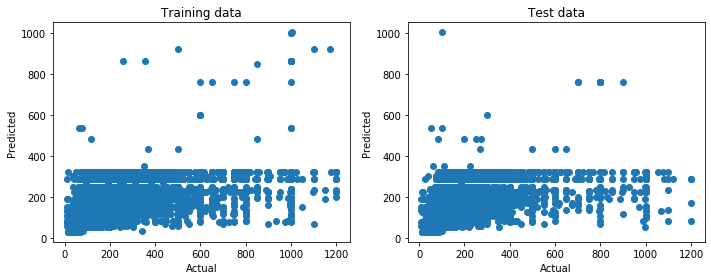

In [87]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
print("\033[1m Performance of training data\033[0m")# print in bold
model_output(y_train,dt_train_pred)
plt.title("Training data")

plt.subplot(1,2,2)
print("\033[1m Performance of test data \033[0m") # print in bold
model_output(y_test,dt_test_pred)
plt.title("Test data")
plt.tight_layout()


## 5.5) Random forest 

In [88]:
# Create RandomForestClassifier object
rf = RandomForestRegressor()#n_estimators=15, max_depth=6)
#rf.fit(Xd_train,y_train)

In [89]:
grid_rf= GridSearchCV(estimator=rf, param_grid=[{"max_depth": [2,3,4,5,6,7,8,9,10], \
                                                 "n_estimators":[20,30,40,50,100],  "max_features":[3,4,5]}],\
                      scoring='r2', cv= 4)

grid_rf.fit(Xd_train,y_train)

GridSearchCV(cv=4, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [90]:
grid_rf.best_estimator_
#score(Xd_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features=5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [91]:
r = RandomForestRegressor(n_estimators=300, max_depth=6,  max_features=4)
cross_val_score(r, Xd_train, y_train, cv=5)

array([0.3615537 , 0.34506261, 0.36489269, 0.37686717, 0.37239386])

In [92]:
rf_train_pred=grid_rf.predict(Xd_train)
rf_test_pred=grid_rf.predict(Xd_test)

 Performance of training data
r2 =  0.5530066070994892
mean_absolute_error =  45.6932943745313
mean_squared_error =  6420.197966432337
 Performance of test data 
r2 =  0.41587946591267566
mean_absolute_error =  51.39356836812804
mean_squared_error =  8646.804921364817


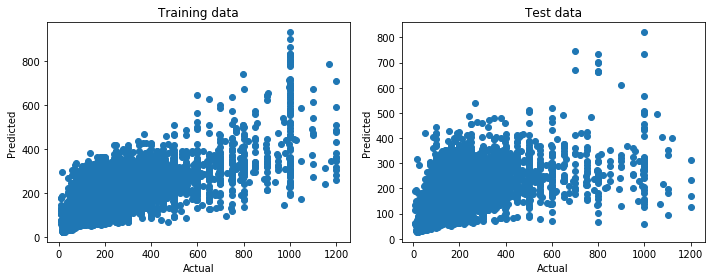

In [93]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
print("\033[1m Performance of training data\033[0m")# print in bold
model_output(y_train,rf_train_pred)
plt.title("Training data")

plt.subplot(1,2,2)
print("\033[1m Performance of test data \033[0m") # print in bold
model_output(y_test, rf_test_pred)
plt.title("Test data")
plt.tight_layout()

## 5.6) XGboost 

In [ ]:
import xgboost as xgb

In [ ]:
data_matrix= xgb.DMatrix(data=Xd_train,label=y_train)

In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.6,
                max_depth = 6, alpha = 10, n_estimators = 50)

In [55]:
xg_reg.fit(Xd_train,y_train)

XGBRegressor(alpha=10, base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.6, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=10,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [56]:
xg_train_pred= xg_reg.predict(Xd_train)
xg_test_pred=xg_reg.predict(Xd_test)

r2 =  0.3671989452108254
mean_absolute_error =  55.03995055331152
mean_squared_error =  9367.428391034577


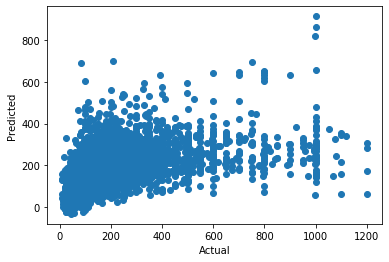

In [57]:
model_output(y_test, xg_test_pred)

# Using catboost

In [95]:
col_cat=['neighbourhood_group',
       'neighbourhood', 'room_type',
       'minimum_nights', 'number_of_reviews', 
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'is_hotel', 'dist_nearest_SubwayEntrance', 'dist_from_PennStation']

In [96]:
xcat= clean_ny[col_cat] 
ycat=clean_ny["price"]
Xcat_train, Xcat_test, ycat_train, ycat_test = train_test_split(xcat, ycat,test_size = 0.3, random_state=42)
 

In [103]:

# initialize Pool
train_pool = Pool(Xcat_train, 
                  ycat_train, cat_features=[0,1,2])
test_pool = Pool(Xcat_test,cat_features=[0,1,2])

# specify the training parameters 
catBR = CatBoostRegressor(iterations=30, 
                          depth=6, 
                          learning_rate=0.8, 
                          loss_function='RMSE')
#train the model
catBR.fit(train_pool)
# make the prediction using the resulting model
cat_train_pred = catBR.predict(train_pool)
cat_test_pred = catBR.predict(test_pool)
print(cat_train_pred)

0:	learn: 100.6401036	total: 14.4ms	remaining: 417ms
1:	learn: 97.3752678	total: 31.8ms	remaining: 445ms
2:	learn: 96.0971856	total: 44.7ms	remaining: 402ms
3:	learn: 95.1685731	total: 95.4ms	remaining: 620ms
4:	learn: 94.8091039	total: 124ms	remaining: 621ms
5:	learn: 94.0802959	total: 156ms	remaining: 626ms
6:	learn: 93.7256047	total: 183ms	remaining: 601ms
7:	learn: 93.2266629	total: 216ms	remaining: 593ms
8:	learn: 92.9538534	total: 226ms	remaining: 527ms
9:	learn: 92.6032098	total: 234ms	remaining: 469ms
10:	learn: 92.4415311	total: 254ms	remaining: 439ms
11:	learn: 92.2513502	total: 283ms	remaining: 424ms
12:	learn: 91.9783332	total: 343ms	remaining: 448ms
13:	learn: 91.8097746	total: 358ms	remaining: 409ms
14:	learn: 91.4934639	total: 390ms	remaining: 390ms
15:	learn: 91.3465314	total: 410ms	remaining: 358ms
16:	learn: 91.1599934	total: 439ms	remaining: 336ms
17:	learn: 90.9171203	total: 453ms	remaining: 302ms
18:	learn: 90.8149938	total: 478ms	remaining: 277ms
19:	learn: 90.615

In [104]:
catBR.feature_importances_

array([ 1.88000776,  7.01527025, 39.91417943,  7.6300224 ,  3.67025136,
        3.0738726 ,  5.92636019,  8.89332167,  2.09683194,  2.77550637,
       17.12437602])

r2 =  0.4110794205887274
mean_absolute_error =  52.00898138456397
mean_squared_error =  8717.860556474001


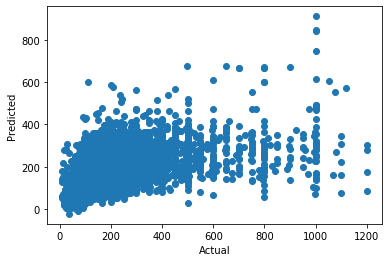

In [105]:
 model_output(ycat_test, cat_test_pred)

## Summary 

The following table shows the summary of models and their preformance. Linear regression with and without corrective action , lasso regression, k-nearest neighbour regression, decision tree regression, random forest ,and catboost was performed. Note that the input data may not be the same for all models. It is adapted according to the nature of the model. For example, for K-nearest neighbour the data was standardized, for decision tree and random forest the input parametrs are encoded differently and for one of the linear model log transformation of price was performed, for catboost model the catagorical variables was feeded as they are (no encoding was performed). The log transformation of price and removal of outlier and leveraging points give better performace than others. 


In [117]:
# models used to train the data
models= ["linear_regresion", "lreg_correction", "lasso", "Knn", "Decision_tree",\
      "Random_forest", "Catboost"]
#trainl_logpred
# actual and predicted values of training data for different models 
train_actual=[y_train, np.log(y_train.drop(out_lev, axis=0)), y_train, yzt, y_train, y_train, ycat_train]
train_pred=[trainl_pred,trainl_logpred, train_lasso_pred ,kn_train_pred, dt_train_pred,rf_train_pred,cat_train_pred]


#actual and predicted values of training data
test_actual=[y_test, np.log(y_test), y_test, yz_test, y_test, y_test, ycat_test]
test_pred =[testl_pred, testl_logpred, test_lasso_pred, kn_test_pred , dt_test_pred ,rf_test_pred,cat_test_pred]

# placeholders for score
r2=[]
mean_abs_err=[]
mean_sqr_err=[]
r2_tst=[]
mean_abs_err_tst=[]
mean_sqr_err_tst=[]

# compute the preformace of training data
for obs, pred  in zip(train_actual,train_pred):
    #performance measure
    r2.append(r2_score(obs, pred)) # r2
    mean_abs_err.append( mean_absolute_error(obs, pred))
    mean_sqr_err.append(mean_squared_error(obs, pred)) 

    #compute the performance of test data    
for obst, predt  in zip(test_actual,test_pred):
    #performance measure
    r2_tst.append(r2_score(obst, predt)) # r2
    mean_abs_err_tst.append( mean_absolute_error(obst, predt))
    mean_sqr_err_tst.append(mean_squared_error(obst, predt))     
#for obst, predt in zip(test_actual,test_pred):
 #   model_output(obst,predt)

In [118]:
# collect the performace of the models 
perf= {"model":models, "r2_train":r2, "mean_abs_err_train":mean_abs_err, "mean_sqr_err_train":mean_sqr_err,\
    "r2_test" :r2_tst, "mean_abs_err_test":mean_abs_err_tst, "mean_sqr_err_test":mean_sqr_err_tst}

In [119]:
pd.DataFrame(perf).set_index("model")

,r2_train,mean_abs_err_train,mean_sqr_err_train,r2_test,mean_abs_err_test,mean_sqr_err_test
model,,,,,,
linear_regresion,0.326613,55.147867,9671.908374,0.326493,56.108488,9970.002326
lreg_correction,0.609827,0.296973,0.142955,0.553961,0.330210,0.203336
lasso,0.326527,55.090724,9673.138152,0.326217,56.041298,9974.095863
Knn,0.529588,0.379678,0.470412,0.336829,0.453797,0.663171
Decision_tree,0.383717,52.235339,8851.716164,0.351714,54.039410,9596.650074
Random_forest,0.553007,45.693294,6420.197966,0.415879,51.393568,8646.804921
Catboost,0.448902,50.097362,7915.463695,0.411079,52.008981,8717.860556


## Including all variables  with dummy

In [121]:
dumm= pd.get_dummies(clean_ny[["neighbourhood_group", "room_type",  'neighbourhood']],drop_first=True)

In [122]:

drop=['id', 'name', 'host_id', 'host_name','neighbourhood_group',
       'neighbourhood', 'room_type', "last_review", 'location']

In [123]:
big= pd.concat([clean_ny,dumm], axis=1)

In [124]:
big_col=big.drop("price", axis=1).columns

In [125]:
predictor=" + ".join(big_col)
formula= "price ~" + predictor

In [126]:
big.drop(drop, axis=1,inplace=True)
#all_columns = "+".join(big.columns - ["price"])

In [127]:
lmm= LinearRegression()

In [128]:
cross_val_score(lmm, big.drop("price", axis=1), big["price"], cv=5 )

array([0.27648352, 0.29593822, 0.32449272, 0.34679405, 0.3269105 ])

In [89]:
y_train.sample

34458    140
21470    135
24896    120
25241    196
39046     89
        ... 
11336    130
44904     80
38289     40
863      121
15859    125
Name: price, Length: 35246, dtype: int64

In [130]:
# Baging: using linear regression and log transformation of price, with 100 number of estimators.

test_score=np.empty(100)
size= datalm.shape[0]
for i in range(100):
  
    sample= datalm.sample(size, replace=True)
    xt=sample.drop("price", axis=1)
    yt= np.log(sample["price"])
    m= LinearRegression().fit(xt,yt)
    test_score[i]=  m.score(xt,yt)#(Xl_test,np.log(y_test))
    
print(sum(test_score)/100)
    

0.5626985384772919
